<a href="https://colab.research.google.com/github/abhaysrivastav/Pytorch/blob/master/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip3 install torch torchvision


     |████████████████████████████████| 2.1MB 51.0MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [23]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

 
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root = '/data', train=True, download=True, transform = transform_train ) 
validation_dataset = datasets.CIFAR10(root = '/data', train=False, download=True, transform = transform ) 

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size = 100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size = 100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image* np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

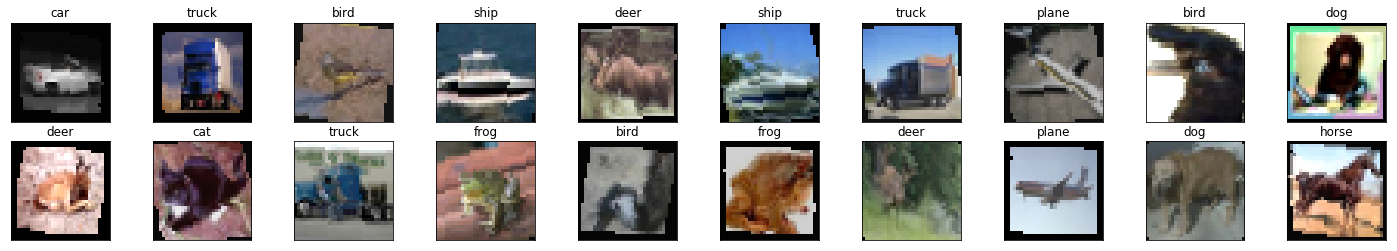

In [26]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
#images = images.to(device)
#labels = labels.to(device)
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1,  xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])
  
  

In [0]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [28]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

In [30]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_loss_correct = []

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_correct = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    #inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
  else:
    with torch.no_grad():
      for val_inputs , val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
       # val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        _, val_preds = torch.max(val_outputs, 1)    
        val_running_loss += val_loss.item()
        val_running_correct += torch.sum(val_preds == val_labels.data)

    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_correct.float()/len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)           
    val_running_loss_correct.append(val_epoch_acc)                                      
    print('epoch : ', (e+1))
    print('training loss: {:.4f}, acc{:.4f}'.format(epoch_loss, epoch_acc.item()) )
    print('Validation loss: {:.4f}, Validation acc{:.4f}'.format(val_epoch_loss, val_epoch_acc.item()) )

print('Training Done!')

epoch :  1
training loss: 1.6924, acc37.8320
Validation loss: 1.4217, Validation acc47.6200
epoch :  2
training loss: 1.3955, acc49.7100
Validation loss: 1.2394, Validation acc55.3800
epoch :  3
training loss: 1.2603, acc54.6840
Validation loss: 1.1651, Validation acc58.8600
epoch :  4
training loss: 1.1697, acc58.3620
Validation loss: 1.0563, Validation acc62.7000
epoch :  5
training loss: 1.1055, acc60.8660
Validation loss: 0.9921, Validation acc64.6900
epoch :  6
training loss: 1.0580, acc62.5520
Validation loss: 0.9537, Validation acc66.5000
epoch :  7
training loss: 1.0206, acc63.7420
Validation loss: 0.9201, Validation acc67.8900
epoch :  8
training loss: 0.9849, acc65.5100
Validation loss: 0.8849, Validation acc69.2200
epoch :  9
training loss: 0.9566, acc66.7160
Validation loss: 0.8827, Validation acc69.1600
epoch :  10
training loss: 0.9335, acc67.3480
Validation loss: 0.8580, Validation acc70.7500
epoch :  11
training loss: 0.9201, acc67.8640
Validation loss: 0.8357, Validati

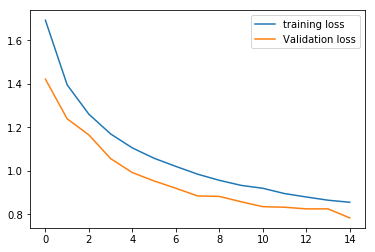

In [31]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(val_running_loss_history, label = 'Validation loss')
plt.legend()

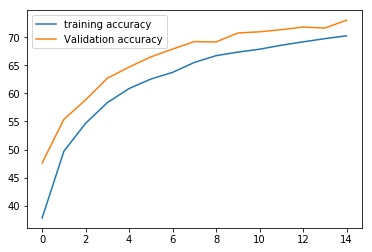

In [32]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_loss_correct, label = 'Validation accuracy')
plt.legend()

Validation accuracy becoming lower so the solution is regularization

In [33]:
!pip3 install pillow==4.0.0 

  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.3.0 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 6.1.0
    Uninstalling Pillow-6.1.0:
      Successfully uninstalled Pillow-6.1.0


In [0]:
import PIL.ImageOps

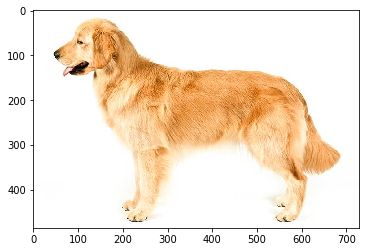

In [47]:
import requests
from PIL import Image
url = 'https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12121353/GoldenRetriever1_stacked.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)


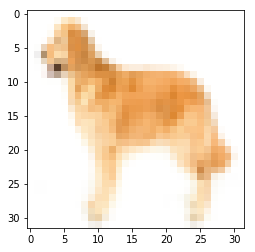

In [48]:
img =transform(img)
plt.imshow(im_convert(img))

In [49]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

dog
